In [1]:
from unittest.mock import inplace

import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from plots.utils.open_llm_leaderboard import get_openllm_leaderboard_data, clean_text, extract_model_info
from plots.utils.plotting import write_figure_to_disk

# Introductory Plot: LLM Zoo & Performance

In [2]:
leaderboard_data = get_openllm_leaderboard_data()
leaderboard_data = leaderboard_data.loc[leaderboard_data["Flagged"] == False]
leaderboard_data = leaderboard_data.loc[leaderboard_data["Official Providers"] == True]
leaderboard_data = leaderboard_data.loc[leaderboard_data["Merged"] == False]
leaderboard_data = leaderboard_data.loc[leaderboard_data["Generation"] > 0]

In [3]:
print(leaderboard_data.columns)

model_vendors_of_interest = ["mistralai", "meta-llama", "Qwen", "google", "microsoft", "ibm-granite"]
leaderboard_data["Model"] = leaderboard_data["Model"].apply(clean_text)
relevant_model_arch = leaderboard_data["Model"].unique()

patterns = []
for vendor in model_vendors_of_interest:
    # Match the vendor name when it's at the start of the string or after a "/"
    patterns.append(f"(^|/){vendor}")

pattern = '|'.join(patterns)
leaderboard_data = leaderboard_data[leaderboard_data["Model"].str.contains(pattern, case=False)]
leaderboard_data = leaderboard_data[leaderboard_data["Base Model"].str.contains(pattern, case=False)]

leaderboard_data[["Vendor", "Model Family", "Version", "param_count", "Purpose"]] = leaderboard_data["Model"].apply(extract_model_info)
leaderboard_data = leaderboard_data.loc[leaderboard_data["Vendor"] != "mlabonne"]


# Rename
leaderboard_data["Vendor"] = leaderboard_data["Vendor"].replace({
    "Qwen": "Qwen",
    "meta-llama": "Meta",
    "nvidia": "NVIDIA",
    "google": "Google",
    "mistralai": "MistralAI",
    "ibm-granite": "IBM",
})

# Fine Filter model families
model_families_of_interest = ['Qwen', 'Llama-', 'gemma-', 'granite-', 'Mistral-']
model_pattern = '|'.join(model_families_of_interest)
leaderboard_data = leaderboard_data[
    (leaderboard_data["Model Family"].str.contains(model_pattern, case=False)) &
    ~(leaderboard_data["Model Family"].str.contains("Meta-Llama-", case=False)) &
    ~(leaderboard_data["Model Family"].str.contains("Mistral-Nemo-Instruct-", case=False)) &
    ~(leaderboard_data["Model Family"].str.contains("Mixtral-", case=False))
]

# Rename model families
leaderboard_data["Model Family"] = leaderboard_data["Model Family"].replace({
    "Qwen": "Qwen",
    "Llama-": "Llama",
    "gemma-": "Gemma",
    "Mixtral-": "Mixtral",
    "granite-": "Granite",
    "Mistral-": "Mistral"
})

def make_family_name(row):
    return row["Vendor"] + "/" + row["Model Family"] + "-" + row["Version"]

def make_model_name(row):

    if row["Model Family"] == "Mistral" or row["Model Family"] == "Mixtral":
        name = row["Vendor"] + "/" + row["Model Family"] + " (" + row["param_count"].upper() + ")"
    else:
        name = row["Vendor"] + "/" + row["Model Family"] + "-" + row["Version"] + " (" + row["param_count"].upper() + ")"

    return name

leaderboard_data["model_name"] = leaderboard_data.apply(make_model_name, axis=1)
leaderboard_data["family_name"] = leaderboard_data.apply(make_family_name, axis=1)

leaderboard_data = leaderboard_data.sort_values(
    by=["Vendor", "family_name", "#Params (B)"],
    ascending=[True, False, True]
)


print(leaderboard_data["family_name"].unique())
print(leaderboard_data["model_name"].unique())
print(len(leaderboard_data))



Index(['eval_name', 'Precision', 'Type', 'T', 'Weight type', 'Architecture',
       'Model', 'fullname', 'Model sha', 'Average ⬆️', 'Hub License', 'Hub ❤️',
       '#Params (B)', 'Available on the hub', 'MoE', 'Flagged',
       'Chat Template', 'CO₂ cost (kg)', 'IFEval Raw', 'IFEval', 'BBH Raw',
       'BBH', 'MATH Lvl 5 Raw', 'MATH Lvl 5', 'GPQA Raw', 'GPQA', 'MUSR Raw',
       'MUSR', 'MMLU-PRO Raw', 'MMLU-PRO', 'Merged', 'Official Providers',
       'Upload To Hub Date', 'Submission Date', 'Generation', 'Base Model'],
      dtype='object')
['Google/Gemma-7' 'Google/Gemma-2' 'IBM/Granite-3.2' 'IBM/Granite-3.1'
 'IBM/Granite-3.0' 'Meta/Llama-3.3' 'Meta/Llama-3.1' 'MistralAI/Mistral-7'
 'Qwen/Qwen-2.5' 'Qwen/Qwen-2']
['Google/Gemma-7 (7B)' 'Google/Gemma-2 (2B)' 'Google/Gemma-2 (9B)'
 'Google/Gemma-2 (27B)' 'IBM/Granite-3.2 (2B)' 'IBM/Granite-3.2 (8B)'
 'IBM/Granite-3.1 (1B)' 'IBM/Granite-3.1 (2B)' 'IBM/Granite-3.1 (3B)'
 'IBM/Granite-3.1 (8B)' 'IBM/Granite-3.0 (1B)' 'IBM/Granite-3.0 (2

/tmp/ipykernel_1890493/3448865112.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  leaderboard_data = leaderboard_data[leaderboard_data["Model"].str.contains(pattern, case=False)]
/tmp/ipykernel_1890493/3448865112.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  leaderboard_data = leaderboard_data[leaderboard_data["Base Model"].str.contains(pattern, case=False)]


Empty DataFrame
Columns: [eval_name, Precision, Type, T, Weight type, Architecture, Model, fullname, Model sha, Average ⬆️, Hub License, Hub ❤️, #Params (B), Available on the hub, MoE, Flagged, Chat Template, CO₂ cost (kg), IFEval Raw, IFEval, BBH Raw, BBH, MATH Lvl 5 Raw, MATH Lvl 5, GPQA Raw, GPQA, MUSR Raw, MUSR, MMLU-PRO Raw, MMLU-PRO, Merged, Official Providers, Upload To Hub Date, Submission Date, Generation, Base Model, Vendor, Model Family, Version, param_count, Purpose, model_name, family_name]
Index: []

[0 rows x 43 columns]
Plot saved.


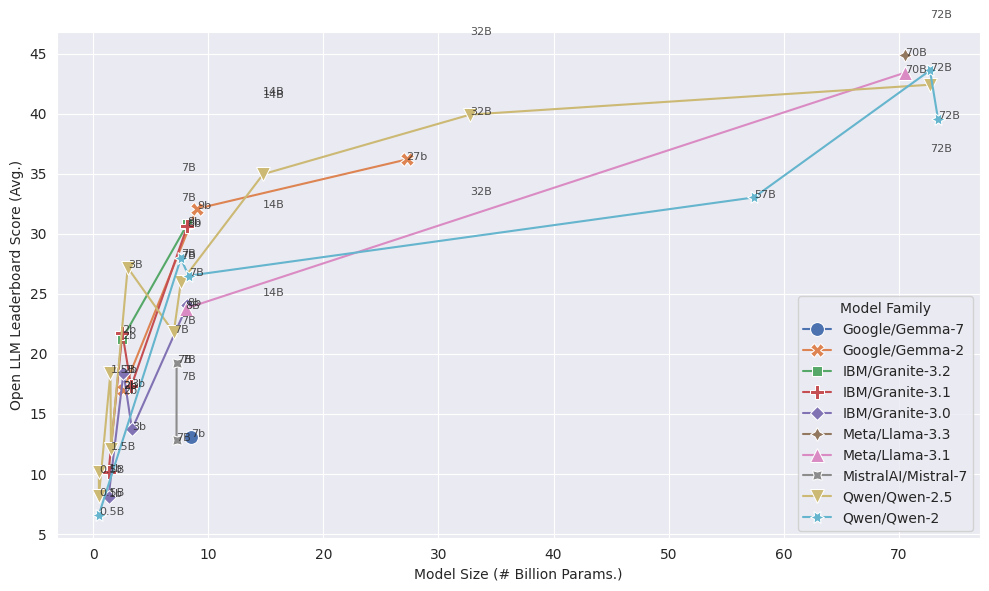

In [4]:
print(leaderboard_data.loc[leaderboard_data["model_name"] == "MistralAI/Mixtral (8X)"])
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=leaderboard_data,
    x="#Params (B)",
    y="Average ⬆️",
    hue="family_name",
    style="family_name",
    palette="deep",  # You can choose a different color palette if you prefer
    # markers=["o", "s", "D", "^", "v"],  # Different markers for different model families
    # linestyles="-",
    markers=True,
    dashes=False,
    markersize=10,
    errorbar=None
)

# Annotate each point with its model name
for _, row in leaderboard_data.iterrows():
    plt.text(
        row["#Params (B)"],         # Slight offset on x-axis
        row["Average ⬆️"],         # Y position
        row["param_count"],        # Text to display
        fontsize=8,                # Smaller font for annotations
        alpha=0.8                  # Slight transparency
    )

# Customize the plot
plt.xlabel("Model Size (# Billion Params.)")
plt.ylabel("Open LLM Leaderboard Score (Avg.)")

# Add a legend with a title
plt.legend(title="Model Family")

# Display the plot
plt.tight_layout()

write_figure_to_disk(
    plt=plt,
    file_name="open_llm_leaderboard_results",
    chapter_name="00_introduction"
)

